In [57]:
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import default_rng as rg
%matplotlib inline
backend = plt.get_backend()
import jpcm
plt.switch_backend(backend)
rng = rg(12345)
from tqdm import tqdm

In [58]:
import torch
import torch.optim as optim
from scipy.optimize import fsolve

In [ ]:
class SCN(torch.nn.Module):
    def __init__(self):
        super(SCN,self).__init__()
        
        # base
        self.rt1 = RootCell(p,use_primes=False)
        self.pc1 = PowerCell(p,use_primes=False)
        
        # encoder
        self.linear1a = torch.nn.Linear(2, p)
        self.linear1b = torch.nn.Linear(2, p) # create powers of unity
        # decoder
        self.linear1d = torch.nn.Linear(p, 2)
        
    def forward(self,x1, x2):
        
        x1 = self.linear1a(x1) # encode
        rr1,ri1 = self.rt1(x1,w=self.weights)
        
        x2 = self.linear1b(x2) # encode
        rr2,ri2 = self.rt1(x2,w=self.weights)
        
        r3 = rr1 @ rr2 - ri1 @ ri2
        i3 = rr1 @ ri2 + ri1 @ rr2
                
        mod = self.pc1(r3,i3,w=self.weights)
        out = self.linear1d(mod)
        return out  

In [69]:
device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # as other apps are currently using gpu

n = 2000
tn = 1000

dt = 4e-3

fdim = 4
x = torch.from_numpy(np.arange(n+tn) * dt)
y = torch.zeros(size=(n+tn,fdim))
y[0] = torch.from_numpy(np.array([1,1,0,0]))

@jit
def dy(yi):
    k1 = 1.2
    k2 = 0.8
    return np.array([-k1*yi[0]*yi[1],
    -k1*yi[0]*yi[1] - k2*yi[1]*yi[2],
    k1*yi[0]*yi[1] - k2*yi[1]*yi[2],
    k2*yi[1]*yi[2]])

@jit
def compute(y,dt,k):
    for i in range(1,k):
        y[i] = torch.from_numpy(dy(y[i-1]))*dt + y[i-1]
    
compute(y,dt,n+tn)
tx = x[n:]

In [72]:
batch_size=30
net = SCN()
net.to(device)
criterion = torch.nn.MSELoss() #CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002, momentum=0.9)
for epoch in tqdm(range(24)): 
    running_loss = 0.0
    for i in range(n//batch_size):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs = net(x[i:i+batch_size])
        loss = criterion(outputs, y[i:i+batch_size])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')

NameError: name 'SCN' is not defined

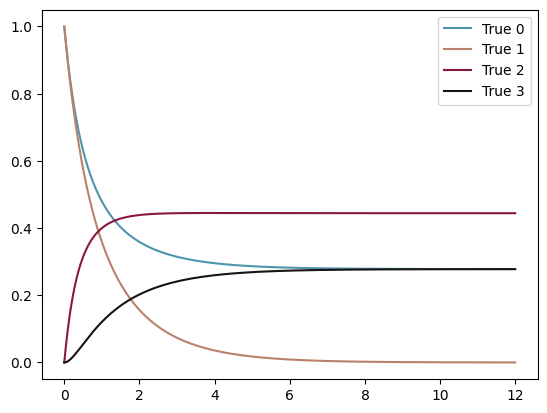

In [70]:
cs = jpcm.get('fuyu').resampled(fdim+1).colors[1:]
for i in range(fdim):
    xn = x.detach().numpy()
    yn = y[:,i].detach().numpy()
    plt.plot(xn,yn,label=f'True {i}',c=cs[i])
    # yhat = net(y)[:,i].detach().numpy()
    # e = (yhat-y)/y
    # plt.scatter(tx.detach().numpy(),yhat,label=f'Predict {i}; MSE={np.mean(e**2)}',c=cs[i], s=2)
plt.legend()
plt.show()
plt.close()